<a href="https://colab.research.google.com/github/rushikeshnakhate/PortfoliOpt/blob/master/multi_optimized_df_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from pathlib import Path
import os
output_dir = Path("/content/drive/MyDrive/")
data_dir = Path("/content/drive/MyDrive/data")
import matplotlib.pyplot as plt
# !pip install tqdm
# !pip install PyPortfolioOpt
# !pip install tabulate
# !pip install dtale
# !pip install -q data-table
import scipy.optimize as sci_opt
from tqdm import tqdm  # Import the tqdm progress b
from google.colab import data_table

In [21]:
import tarfile

def unzip_files():
  from google.colab import files
  import zipfile

  # After uploading, you can unzip the file
  import zipfile
  import os


  # zip_filename = '/content/drive/MyDrive/data.zip'
  # # Replace 'data.zip' with the name of your uploaded zip file
  # with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
  #     zip_ref.extractall(output_dir)

  tar_filename = '/content/drive/MyDrive/data.tar.gz'
  with tarfile.open(tar_filename, 'r:gz') as tar_ref:
    tar_ref.extractall(output_dir)

  print("Directory uploaded and extracted successfully to Google Drive.")
# unzip_files()

In [22]:
# ! rm -rf output_dir/MyDrive/*pkl
# ! ls -lrt output_dir/MyDrive/*pkl
# ! rm -rf  /content/drive/MyDrive/data

In [23]:
from datetime import datetime, timedelta
def generate_month_date_ranges(year, months=None):
    """Generate start_date and end_date (without time) for each month in the specified year.

    Args:
        year (int): The year for which to generate the month ranges.
        months (list of int, optional): Specific months to generate ranges for (1-12).

    Returns:
        list of tuples: Each tuple contains the start and end date for the specified months.
    """
    if months is None:
        months = range(1, 13)  # Default to all months if none specified

    month_ranges = []
    for month in months:
        start_date = datetime(year, month, 1).date()
        if month == 12:
            end_date = (datetime(year + 1, 1, 1) - timedelta(days=1)).date()
        else:
            end_date = (datetime(year, month + 1, 1) - timedelta(days=1)).date()
        month_ranges.append((start_date, end_date))

    return month_ranges

def create_current_month_directory(start_date, output_dir):
    current_month = start_date.strftime("%Y%m")
    current_month_dir = output_dir / current_month
    # current_month_dir.rmdir(parents=True, exist_ok=True)
    return current_month_dir

In [99]:

def load_data_and_plot(start_date, data_dir, plot_func):
    """
    Function to load data for a specific date range and plot using the given plot function.

    Args:
    start_date (datetime): The start date of the month for data loading.
    data_dir (str): The directory where the data is stored.
    plot_func (function): A function to plot the data (either bar plot or 3D plot).
    """
    current_month_dir = create_current_month_directory(start_date, data_dir)
    data_pkl_filepath = os.path.join(current_month_dir, "data.pkl")
    expected_return_pkl_filepath = os.path.join(current_month_dir, "expected_return.pkl")
    optimization_pkl_filepath = os.path.join(current_month_dir, "optimization.pkl")

    # Load data
    data = pd.read_pickle(data_pkl_filepath)
    expected_return_df = pd.read_pickle(expected_return_pkl_filepath)
    optimization_df = pd.read_pickle(optimization_pkl_filepath)

    # Format the month as 'YYYY-MM' for the title
    current_month = start_date.strftime('%Y-%m')
    # Call the provided plot function
    # print("using optimization_pkl_filepath=optimization_pkl_filepath{}".format(optimization_pkl_filepath))
    return plot_func(optimization_df)

In [100]:
import matplotlib.pyplot as plt
import math

# Function to calculate performance and plot pie charts for the best and worst portfolios
def get_performance_and_plot_pie(df1):
    df = df1.copy()
    # Normalize the columns (Expected Annual Return, Annual Volatility, Sharpe Ratio)
    df['Return_Score'] = df['Expected Annual Return'] / df['Expected Annual Return'].max()
    df['Volatility_Score'] = df['Annual Volatility'].max() / df['Annual Volatility']  # Inverted because lower is better
    df['Sharpe_Score'] = df['Sharpe Ratio'] / df['Sharpe Ratio'].max()

    # Combine the scores into a total score (adjust weights as needed)
    df['Total_Score'] = df['Return_Score'] + df['Volatility_Score'] + df['Sharpe_Score']

    # Get the top 2 best portfolios
    top_best = df.nlargest(2, 'Total_Score')

    # Get the bottom 2 worst portfolios
    bottom_worst = df.nsmallest(2, 'Total_Score')

    return top_best, bottom_worst

In [101]:
# Function to plot pie charts for portfolios (top or bottom) with dynamically calculated grid layout
def plot_portfolios(df, start_date, portfolio_type="top"):
    """
    Plots pie charts for the portfolios' weight allocations and shows their details below each chart,
    with increased pie chart size.

    Parameters:
    df (pd.DataFrame): The dataframe containing the portfolios (either top or bottom)
    portfolio_type (str): Specifies whether it's "top" or "bottom" portfolio
    """
    # Determine the number of portfolios to plot
    num_portfolios = len(df)

    # Calculate number of rows and columns dynamically
    ncols = 2  # Keep two columns for side-by-side plotting
    nrows = math.ceil(num_portfolios / ncols)  # Number of rows is based on number of portfolios

    # Set up the grid layout for the subplots, dynamically adjusting figure size
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3.5))

    # Flatten the axs array to easily iterate over it (even for 2D grid)
    axs = axs.flatten()

    for i in range(num_portfolios):
        # Get portfolio's weights and details
        weights_dict = df.iloc[i]['Weights']
        if isinstance(weights_dict, str):
            weights_dict = eval(weights_dict)
        weights_dict = {k: v for k, v in weights_dict.items() if v > 0}

        # Plot portfolio pie chart with increased size and reduced ticker font size
        tickers = list(weights_dict.keys())
        weights = list(weights_dict.values())
        axs[i].pie(weights, labels=tickers, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8}, radius=1.2)
        axs[i].set_title(f'{start_date} {portfolio_type.capitalize()} Portfolio at Index {df.index[i]}', fontsize=10)
        axs[i].axis('equal')

        # Create a text block with portfolio details below the pie chart
        optimizer_type = df.iloc[i].get('Optimizer', 'N/A')  # Assuming 'Optimizer' is the column name
        return_type = df.iloc[i].get('Expected Return Type', 'N/A')    # Assuming 'Expected Return Type' is the column name
        risk_type = df.iloc[i].get('Risk Model', 'N/A')        # Assuming 'Risk Model' is the column name

        # Format the text string with these details
        text_str = f"Expected Return Type: {return_type}\nRisk Model: {risk_type}\nOptimizer: {optimizer_type}"

        # Add text below the pie chart
        axs[i].text(0.5, -0.4, text_str, ha='center', fontsize=8, transform=axs[i].transAxes, bbox=dict(facecolor='white', alpha=0.7))

    # Turn off any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    # Adjust layout with more control for spacing
    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    # Show the plot
    plt.show()

# Example usage:
# top_best, bottom_worst = get_performance_and_plot_pie(optimized_df_cleaned)
# plot_portfolios(top_best, start_date="2023-01-01", portfolio_type="top")
# plot_portfolios(bottom_worst, start_date="2023-01-01", portfolio_type="bottom")

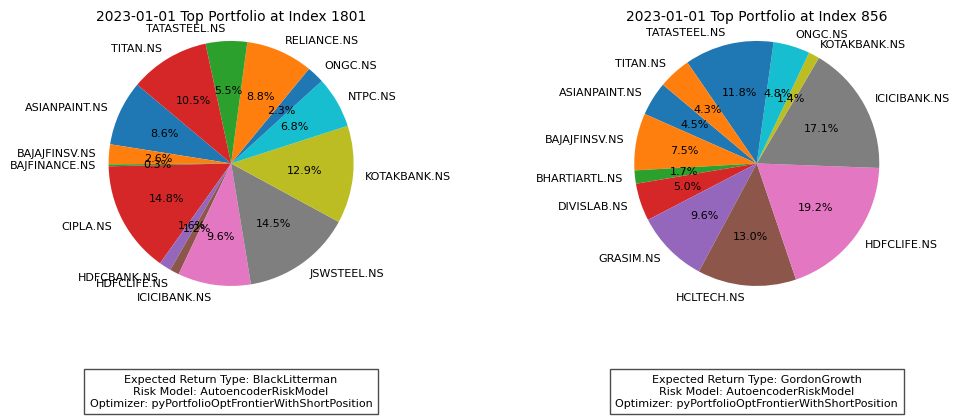

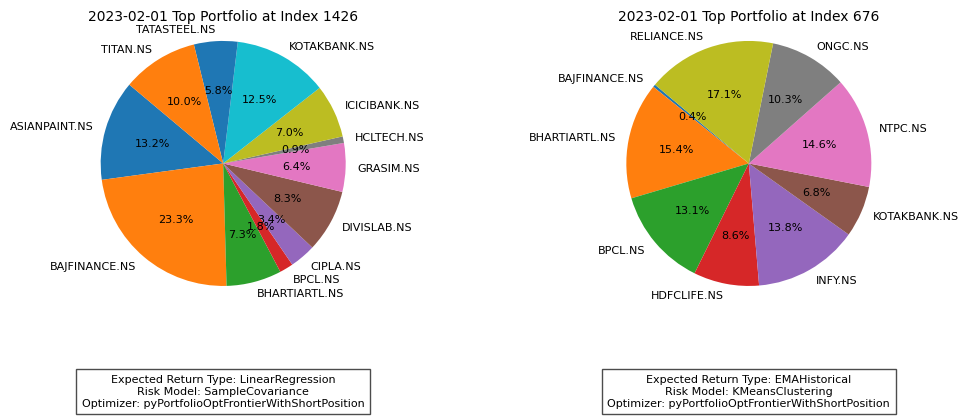

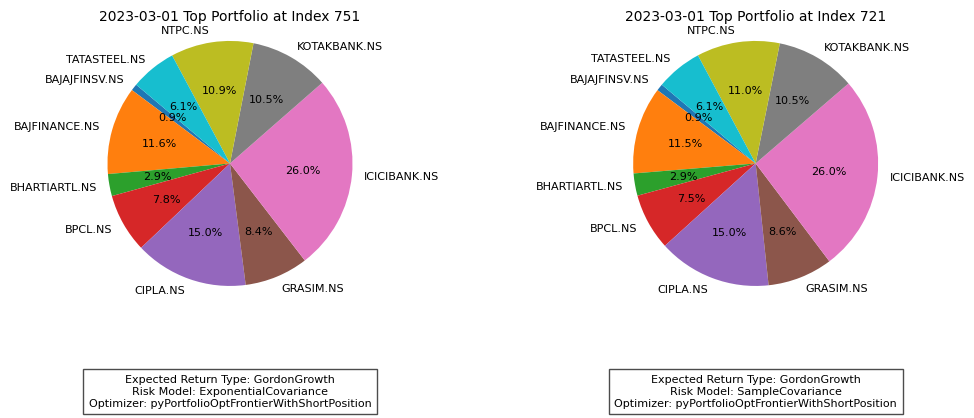

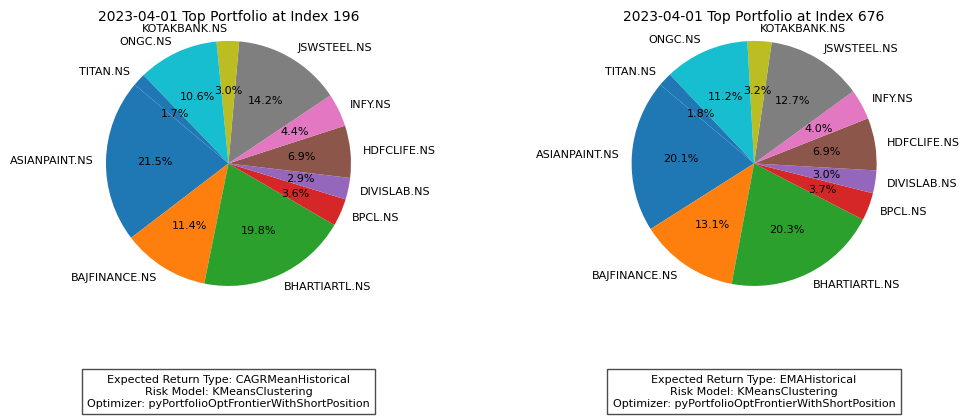

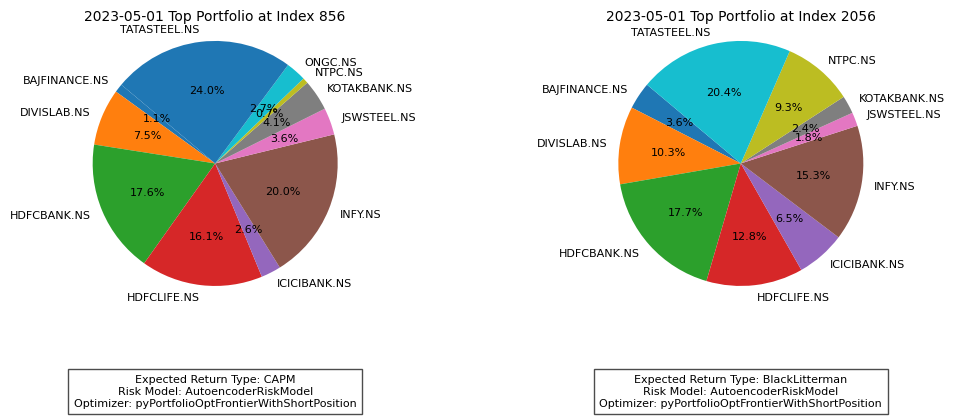

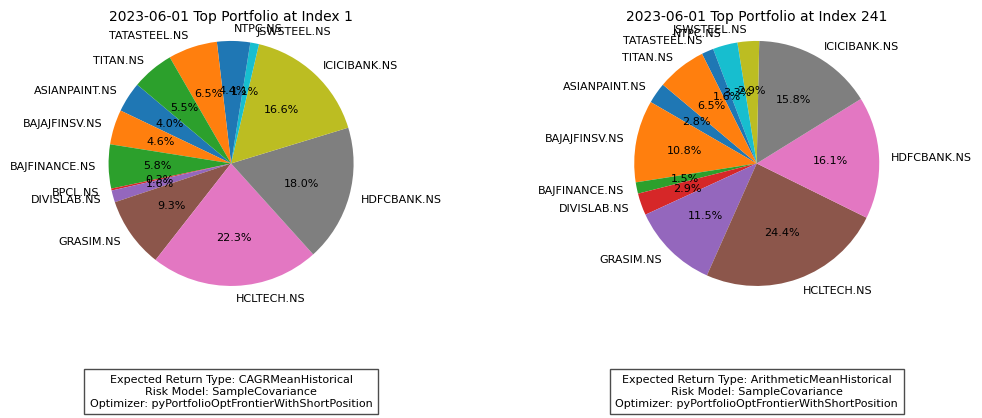

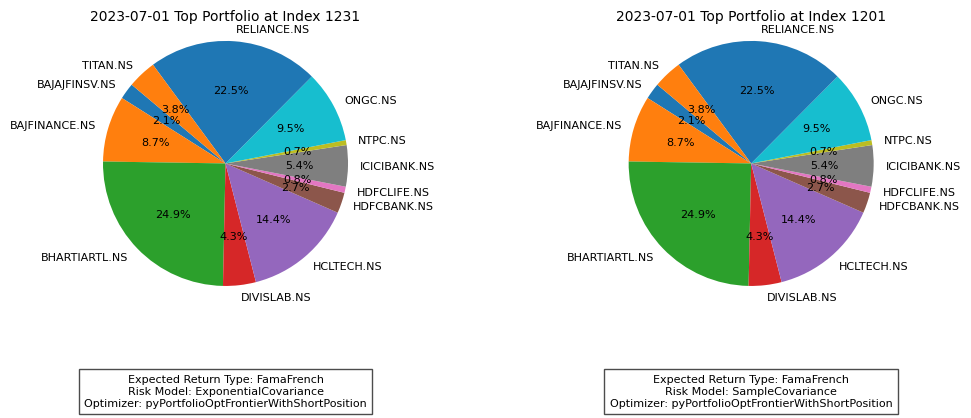

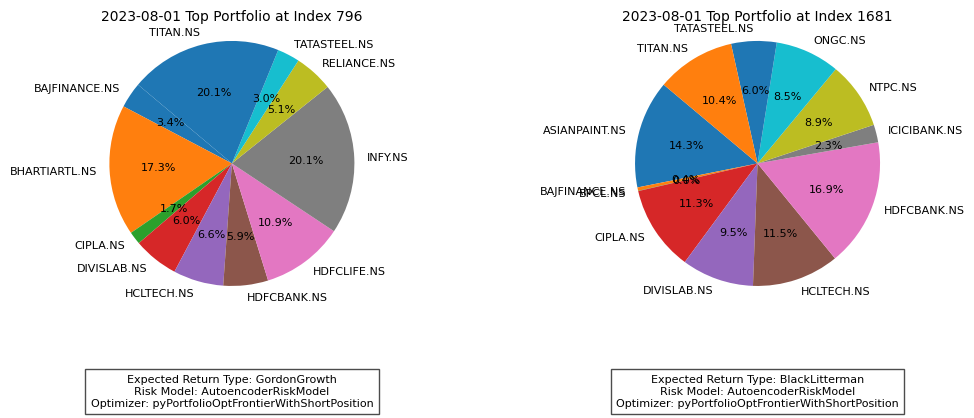

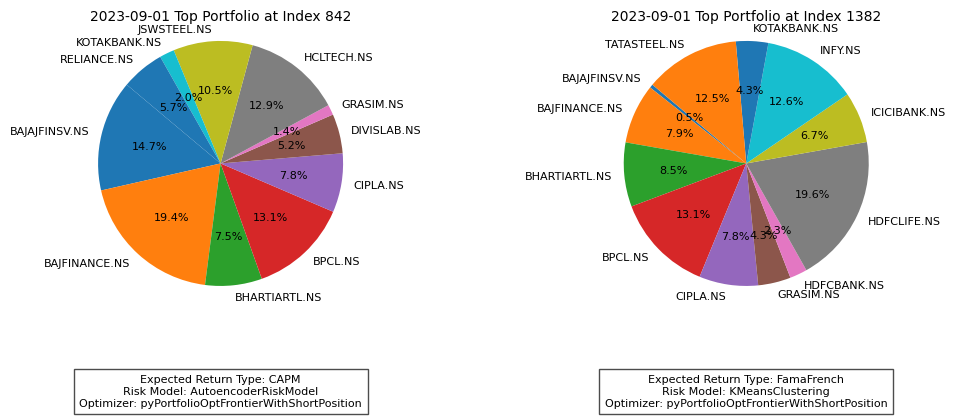

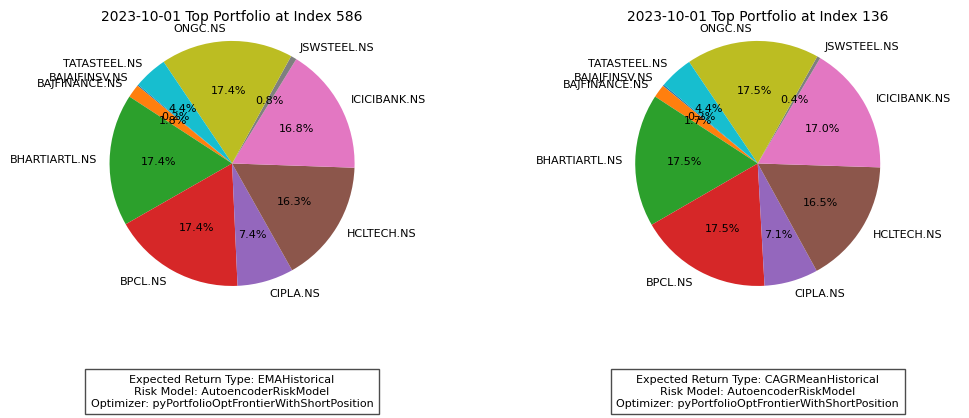

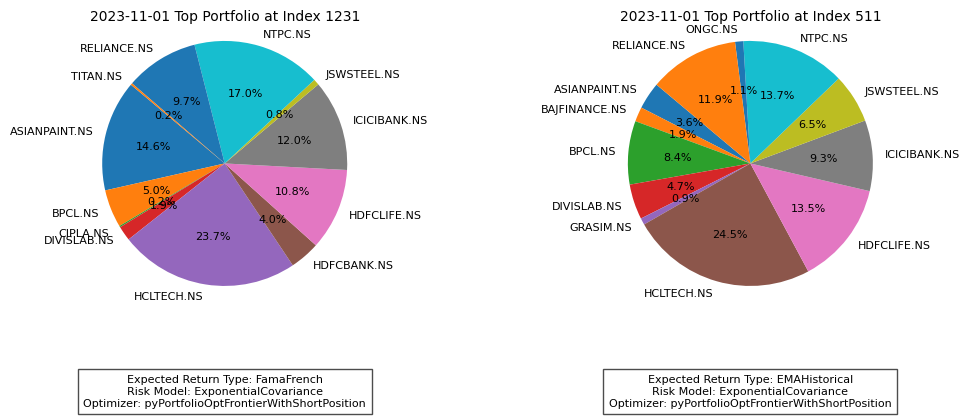

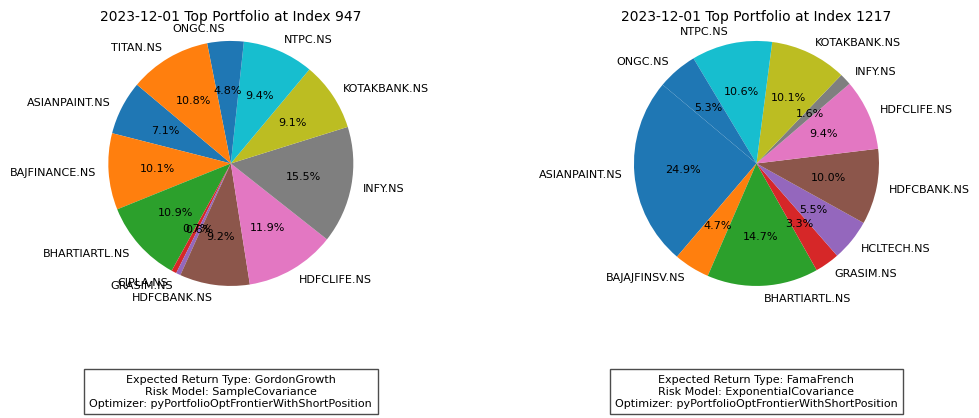

In [102]:
if __name__ == "__main__":
    year = 2023
    # Generate date ranges for alternate months in 2023 (Jan, Mar, May, Jul, Sep, Nov)
    # plot generate current and next month
    month_ranges = generate_month_date_ranges(year)

    # # Plot all bar charts first
    for start_date, end_date in month_ranges:
       top_best, bottom_worst = load_data_and_plot(start_date, data_dir, get_performance_and_plot_pie)
       plot_portfolios(top_best,start_date,"top")

In [97]:
# if __name__ == "__main__":
#     year = 2023
#     # Generate date ranges for alternate months in 2023 (Jan, Mar, May, Jul, Sep, Nov)
#     # plot generate current and next month
#     month_ranges = generate_month_date_ranges(year,months=[1])

#     # # Plot all bar charts first
#     for start_date, end_date in month_ranges:
#         top_best, bottom_worst = load_data_and_plot(start_date, data_dir, get_performance_and_plot_pie)
#         df = pd.read_pickle(Path(r"/content/drive/MyDrive/data/202301/optimization.pkl"))
#         error_rows = df['Weights'].astype(str).str.contains("error", case=False,na=False)
#         if not error_rows.any():
#           print(error_rows)
#         display(df)

using optimization_pkl_filepath=optimization_pkl_filepath/content/drive/MyDrive/data/202301/optimization.pkl
0       False
1       False
2       False
3       False
4       False
        ...  
1870    False
1871    False
1872    False
1873    False
1874    False
Name: Weights, Length: 1875, dtype: bool


,Expected Return Type,Risk Model,Optimizer,Weights,Expected Annual Return,Annual Volatility,Sharpe Ratio
0,CAGRMeanHistorical,SampleCovariance,pyPortfolioOptFrontier,"{'ASIANPAINT.NS': 0.0, 'BAJAJFINSV.NS': 0.0, '...",2.423074,0.175651,13.680925
1,CAGRMeanHistorical,SampleCovariance,pyPortfolioOptFrontierWithShortPosition,"{'ASIANPAINT.NS': -0.59827, 'BAJAJFINSV.NS': -...",4.729312,0.085072,55.356886
2,CAGRMeanHistorical,SampleCovariance,MVRiskFolioOptimizer,"{'ASIANPAINT.NS': 2.4882307362325963e-12, 'BAJ...",1.156757,0.164461,7.033624
3,CAGRMeanHistorical,SampleCovariance,MADRiskFolioOptimizer,"{'ASIANPAINT.NS': 6.098921410656362e-11, 'BAJA...",1.070182,0.158650,6.745561
4,CAGRMeanHistorical,SampleCovariance,MSVRiskFolioOptimizer,"{'ASIANPAINT.NS': 3.802148444610364e-09, 'BAJA...",1.289586,0.187518,6.877133
...,...,...,...,...,...,...,...
1870,BlackLitterman,CopulaRiskModel,MDDRiskFolioOptimizer,"{'ASIANPAINT.NS': 4.1595296851517936e-11, 'BAJ...",0.660370,0.118211,5.586359
1871,BlackLitterman,CopulaRiskModel,ADDRiskFolioOptimizer,"{'ASIANPAINT.NS': 1.2948333164800339e-09, 'BAJ...",1.303207,0.190290,6.848514
1872,BlackLitterman,CopulaRiskModel,CDaRRiskFolioOptimizer,"{'ASIANPAINT.NS': 5.449702703227784e-10, 'BAJA...",0.660370,0.118211,5.586359
1873,BlackLitterman,CopulaRiskModel,UCIRiskFolioOptimizer,"{'ASIANPAINT.NS': 4.656686215575346e-10, 'BAJA...",1.285589,0.187984,6.838835
